Scikit-learn HistGradientBoostingRegressor() model on MDA_dataframeArthur.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.
MAE en RMSE can be compared to other models.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df_fil = df[df['object_id']==255443]
df_fil = df_fil.sort_values(by='result_timestamp')
df_fil['result_timestamp'] = pd.to_datetime(df_fil['result_timestamp'],format='%Y-%m-%d %H:%M:%S')
df_noisedelay = df_fil[['result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay = df_noisedelay.drop('laeq', axis=1)
df_fil = pd.merge(df_fil,df_noisedelay, on='result_timestamp',validate='1:1')
df_fil_nd = df_fil.drop(['object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)
df_fil

C:\Users\Arthur\AppData\Local\Temp\ipykernel_10052\3924323217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_10052\3924323217.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']


,object_id,result_timestamp,laeq,date,time,hour,weekday,month,weekend,day_time,...,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3,laeq_delayed
0,255443,2022-01-02 00:00:00,41.985767,2022-01-02,00:00:00,0,Sunday,1,True,Sunday 00:00:00,...,0.0,0.0,-12.0,0.10,0.0,12.28,12.28,12.223,12.29677,54.790667
1,255443,2022-01-02 00:10:00,40.954667,2022-01-02,00:10:00,0,Sunday,1,True,Sunday 00:10:00,...,0.0,0.0,-23.0,0.09,0.0,12.33,12.33,12.273,12.35607,48.605833
2,255443,2022-01-02 00:20:00,37.623667,2022-01-02,00:20:00,0,Sunday,1,True,Sunday 00:20:00,...,0.0,0.0,-7.0,0.05,0.0,12.39,12.39,12.333,12.34995,54.277833
3,255443,2022-01-02 00:30:00,36.445333,2022-01-02,00:30:00,0,Sunday,1,True,Sunday 00:30:00,...,0.0,0.0,-32.0,0.17,0.0,12.42,12.42,12.363,12.33459,50.025333
4,255443,2022-01-02 00:40:00,38.298000,2022-01-02,00:40:00,0,Sunday,1,True,Sunday 00:40:00,...,0.0,0.0,29.0,0.03,0.0,12.51,12.51,12.453,12.35354,48.907333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52243,255443,2022-12-31 23:10:00,52.203333,2022-12-31,23:10:00,23,Saturday,12,True,Saturday 23:10:00,...,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797,50.290833
52244,255443,2022-12-31 23:20:00,54.622833,2022-12-31,23:20:00,23,Saturday,12,True,Saturday 23:20:00,...,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.57995,49.906667
52245,255443,2022-12-31 23:30:00,56.135667,2022-12-31,23:30:00,23,Saturday,12,True,Saturday 23:30:00,...,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846,49.204667
52246,255443,2022-12-31 23:40:00,59.380333,2022-12-31,23:40:00,23,Saturday,12,True,Saturday 23:40:00,...,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641,49.829333


In [3]:
df_fil_nd = df_fil_nd[df_fil_nd.isna()['LC_HUMIDITY']==False]
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Monday', value=0)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Thursday', value=3)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Friday', value=4)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Saturday', value=5)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Sunday', value=6)

df_fil_nd

,laeq,hour,weekday,month,weekend,holiday,exam_period,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,laeq_delayed
0,41.985767,0,6,1,True,True,False,80.0,9.00,37.0,0.0,0.0,0.0,-12.0,0.10,0.0,12.28,54.790667
1,40.954667,0,6,1,True,True,False,80.0,9.05,38.0,0.0,0.0,0.0,-23.0,0.09,0.0,12.33,48.605833
2,37.623667,0,6,1,True,True,False,80.0,9.11,37.0,0.0,0.0,0.0,-7.0,0.05,0.0,12.39,54.277833
3,36.445333,0,6,1,True,True,False,79.0,8.99,38.0,0.0,0.0,0.0,-32.0,0.17,0.0,12.42,50.025333
4,38.298000,0,6,1,True,True,False,79.0,9.01,37.0,0.0,0.0,0.0,29.0,0.03,0.0,12.51,48.907333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52243,52.203333,23,5,12,True,True,False,52.0,6.79,38.0,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,50.290833
52244,54.622833,23,5,12,True,True,False,52.0,6.74,38.0,0.0,0.0,0.0,5.0,0.29,0.0,16.61,49.906667
52245,56.135667,23,5,12,True,True,False,52.0,6.62,37.0,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,49.204667
52246,59.380333,23,5,12,True,True,False,52.0,6.60,38.0,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,49.829333


The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [20]:
y = df_fil_nd["laeq"]
X = df_fil_nd.drop(["laeq","laeq_delayed"], axis="columns")

In [21]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=4320,
    max_train_size=10000,
    test_size=1000,
)

In [22]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
32925,19,4,8,False,True,False,93.0,19.19,32.0,0.0,0.0,0.003,0.0,0.0,0.0,20.28
32926,19,4,8,False,True,False,93.0,19.11,32.0,0.0,0.0,0.003,0.0,0.0,0.0,20.22
32927,19,4,8,False,True,False,93.0,19.10,31.0,0.0,0.0,0.003,0.0,0.0,0.0,20.22
32928,20,4,8,False,True,False,93.0,19.08,32.0,0.0,0.0,0.003,0.0,0.0,0.0,20.22
32929,20,4,8,False,True,False,93.0,19.19,31.0,0.0,0.0,0.003,0.0,0.0,0.0,20.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42923,5,4,10,False,False,False,81.0,13.38,38.0,0.0,0.0,0.000,0.0,0.0,0.0,16.72
42924,6,4,10,False,False,False,81.0,13.47,37.0,0.0,0.0,0.000,0.0,0.0,0.0,16.76
42925,6,4,10,False,False,False,81.0,13.39,38.0,0.0,0.0,0.000,0.0,0.0,0.0,16.72
42926,6,4,10,False,False,False,82.0,13.60,37.0,0.0,0.0,0.000,0.0,0.0,0.0,16.68


In [23]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
36925,14,4,9,False,True,False,86.0,10.93,32.0,64.0,0.0,0.004,35.0,0.19,132.0,13.15
36926,14,4,9,False,True,False,86.0,10.94,31.0,55.0,0.0,0.004,-106.0,0.03,86.0,13.25
36927,14,4,9,False,True,False,86.0,10.82,32.0,106.0,0.0,0.004,-42.0,0.06,97.0,13.18
36928,14,4,9,False,True,False,84.0,10.52,32.0,127.0,0.0,0.004,15.0,0.21,101.0,13.10
36929,14,4,9,False,True,False,81.0,9.88,31.0,77.0,0.0,0.004,9.0,0.28,91.0,13.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46923,0,4,11,False,False,False,82.0,8.54,38.0,0.0,0.0,0.000,96.0,0.11,0.0,11.55
46924,0,4,11,False,False,False,82.0,8.61,37.0,0.0,0.0,0.000,81.0,0.25,0.0,11.61
46925,0,4,11,False,False,False,84.0,8.86,38.0,0.0,0.0,0.000,34.0,0.06,0.0,11.58
46926,1,4,11,False,False,False,84.0,8.87,37.0,0.0,0.0,0.000,-129.0,0.02,0.0,11.48


In [24]:
# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.09,0.10,0.11,0.12,0.13),
    'max_leaf_nodes': (11,12,13,14)}
model = GradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=10000, n_splits=5, test_size=1000),
             estimator=GradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.09, 0.1, 0.11, 0.12, 0.13),
                         'max_leaf_nodes': (11, 12, 13, 14)})

In [25]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.79


In [26]:
model_grid_search.predict(X.iloc[0:5])

array([41.39252746, 41.39252746, 41.39252746, 41.40854443, 41.39252746])

In [27]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.1, 'max_leaf_nodes': 14}


In [28]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,1.702168,0.137181,0.002992,0.000891,0.1,14,"{'learning_rate': 0.1, 'max_leaf_nodes': 14}",0.764794,0.740835,0.750562,0.686367,0.478086,0.684129,0.106390,1
6,1.611695,0.022417,0.003191,0.001466,0.1,13,"{'learning_rate': 0.1, 'max_leaf_nodes': 13}",0.767751,0.740922,0.735165,0.683254,0.478835,0.681185,0.104810,2
4,1.589436,0.049208,0.002793,0.000747,0.1,11,"{'learning_rate': 0.1, 'max_leaf_nodes': 11}",0.764915,0.735227,0.735165,0.686413,0.478949,0.680134,0.103698,3
5,1.542953,0.040333,0.002802,0.000404,0.1,12,"{'learning_rate': 0.1, 'max_leaf_nodes': 12}",0.767751,0.728036,0.735165,0.686367,0.475251,0.678514,0.104883,4
2,1.666943,0.027311,0.002900,0.000803,0.09,13,"{'learning_rate': 0.09, 'max_leaf_nodes': 13}",0.768994,0.703072,0.748290,0.703937,0.449426,0.674744,0.115512,5


In [29]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [30]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
7,0.1,14,0.684129,0.106390,1
6,0.1,13,0.681185,0.104810,2
4,0.1,11,0.680134,0.103698,3
5,0.1,12,0.678514,0.104883,4
2,0.09,13,0.674744,0.115512,5
1,0.09,12,0.674252,0.115361,6
11,0.11,14,0.674234,0.132317,7
8,0.11,11,0.674207,0.132575,8
9,0.11,12,0.673977,0.129227,9
10,0.11,13,0.672005,0.128390,10


In [31]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,11,12,13,14
param_learning_rate,,,,
0.09,0.671384,0.674252,0.674744,0.667580
0.10,0.680134,0.678514,0.681185,0.684129
0.11,0.674207,0.673977,0.672005,0.674234
0.12,0.668001,0.665657,0.667300,0.669668
0.13,0.669642,0.668537,0.666545,0.666138


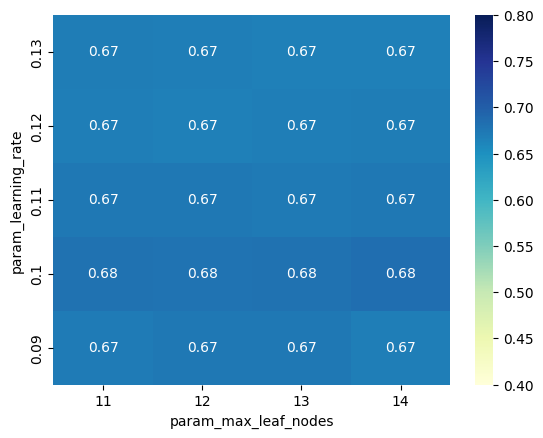

In [32]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

Mean Absolute Error:     2.827 +/- 0.531
Root Mean Squared Error: 3.591 +/- 0.536


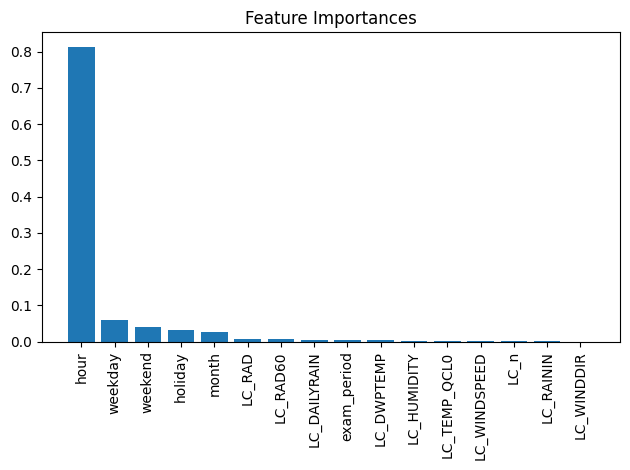

In [36]:
#run gradient boosting model and plot feature importances
import numpy as np
import matplotlib.pyplot as plt

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

    # Fit the model on the data
    model.fit(X, y)

    # Retrieve feature importances
    feature_importances = model.named_steps['gradientboostingregressor'].feature_importances_
    feature_names = X.columns

    # Sort feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    # Plot feature importances
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation='vertical')
    plt.tight_layout()
    plt.show()

gbrt_pipeline = make_pipeline(GradientBoostingRegressor(max_leaf_nodes=14, learning_rate=0.10))
evaluate(gbrt_pipeline, X, y, cv=ts_cv)


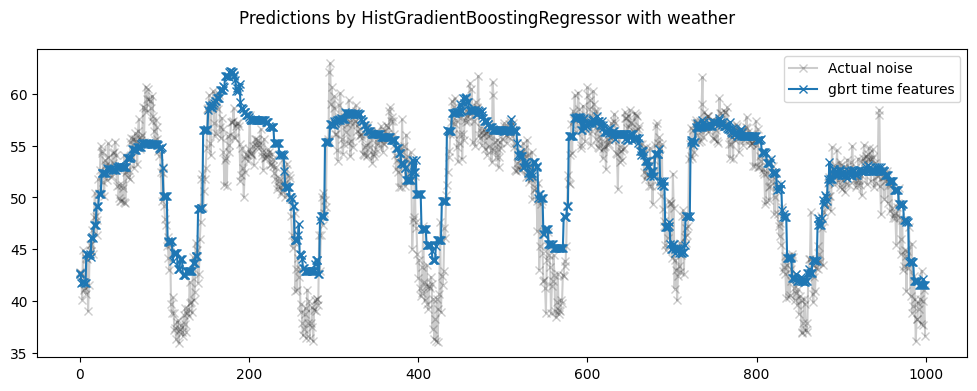

In [37]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


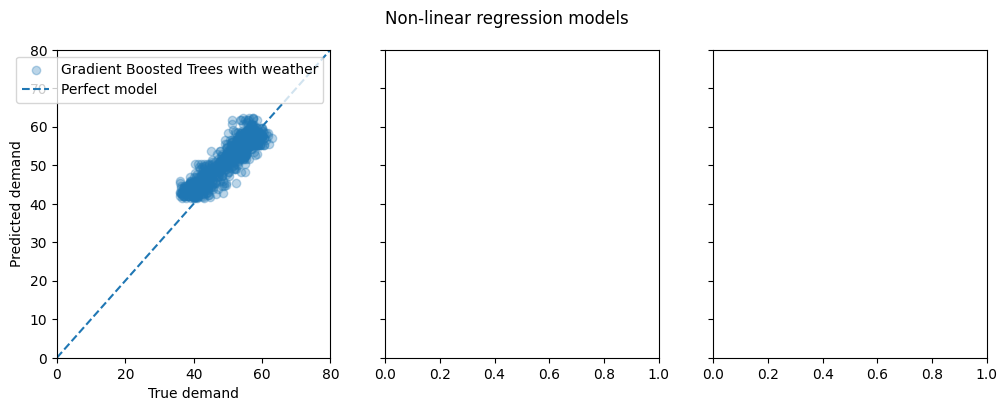

In [38]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()